In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm

from sklearn.model_selection import ParameterGrid

import sys
sys.path.append('../')
sys.path.append('../src/')

from src.Models.generative import *
from src.detection import *

# Approaches to compare the two data-copying metrics

The two metrics are:
- Copying Rate: Value between 0 and 1, where 0 means no copying and 1 means all copying.
- Test Statistic: Values below -3 are considered to be significant. The more negative the value, the more significant the copying. 

**General Idea:**
We want to transform the copying rate into a test statistic or vice versa.

## Create Test Statistic from Copying Rate
<!-- 
If we have access to the true distribution we can establish a distribution of copying rates corresponding to the null hypothesis, i.e. no copying. We can then calculate the z-score of the observed copying rate and compare it to the null distribution.  -->

Idea from Bhattacharjee et al (2023):
1. Compute $cr_p$, which is an estimate for the data copying rate when the generated distribution exactly equals p over 1000 different instances (each instance corresponding to a freshly drawn training set S). 
2. Compute $cr_q$ when q is as above. 
3. Output the fraction of the time that $cr_p > cr_q$, thus giving us a P-value by giving us the rate at which the null-hypothesis gives results as significant as those that we observe. If the P-value is below 0.05, we reject the null hypothesis, i.e. we conclude that the model is data copying.

Example implementation below, basically this replicates the experiments by Bhattacharjee et al (2023).

In [2]:
l = 1000 # In the paper, they use 1000
n_trials = 10 # In the paper they use 10

p = Halfmoons(noise=0.1)
det = DataCopyingDetector()

cr_p = np.zeros(l)
for i in tqdm(range(l)):
    X = p.sample(2000) # draw a fresh sample from the distribution
    cr_p[i] = det.estimate_cr(S=X, q=p, m=1000)

cr_q = np.zeros(n_trials)
for i in tqdm(range(n_trials)):
    X = p.sample(2000)
    q = MixedModel(rho=0.4).fit(X)
    cr_q[i] = det.estimate_cr(S=X, q=q, m=1000)

# Calculate p-values as fraction that cr_q is smaller than cr_p
p_values = np.zeros(n_trials)
for i in range(n_trials):
    p_values[i] = np.mean(cr_q[i] < cr_p)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:01<00:00,  7.10it/s]


In [3]:
# meehan et al. 
p = Halfmoons(noise=0.1).fit()
X_train = p.sample(2000)
X_test = p.sample(1000)
q = MixedModel(rho=0.4).fit(X_train)

det = ThreeSampleDetector(k=5)
C_T = det.C_T(Q=q, X_train=X_train, X_test=X_test, num_trials=10) 
C_T

array([ 0.45611064, -0.20661269,  0.46892535,  0.44743116, -0.60812357,
        0.43599947, -0.56464848,  0.25233845, -0.27483805,  0.16335587])

In [4]:
print(f"Result Algorithm 1: {np.median(p_values)}") # output median p-value
print(f"Significant?: {np.median(p_values) < 0.05}") # output whether the p-value is significant
print(f"Result Algorithm 2: {np.median(C_T)}") # output median C_T statistic
print(f"Significant?: {np.median(C_T) < -3}") # output whether the C_T statistic is significant

Result Algorithm 1: 0.0
Significant?: True
Result Algorithm 2: 0.2078471605358898
Significant?: False


In [5]:
# do the same with 1d algorithm
l = 1000 # In the paper, they use 1000
n_trials = 10 # In the paper they use 10

p = Halfmoons(noise=0.1)
det = DataCopyingDetector()

cr_p = np.zeros(l)
for i in tqdm(range(l)):
    X = p.sample(2000) # draw a fresh sample from the distribution
    cr_p[i] = det.estimate_cr_multiple_proj(S=X, q=p, m=1000)

cr_q = np.zeros(n_trials)
for i in tqdm(range(n_trials)):
    X = p.sample(2000)
    q = MixedModel(rho=0.4).fit(X)
    cr_q[i] = det.estimate_cr_multiple_proj(S=X, q=q, m=1000)

# Calculate p-values as fraction that cr_q is smaller than cr_p
p_values = np.zeros(n_trials)
for i in range(n_trials):
    p_values[i] = np.mean(cr_q[i] < cr_p)


print(f"Result Algorithm 1: {np.median(p_values)}") # output median p-value
print(f"Significant?: {np.median(p_values) < 0.05}") # output whether the p-value is significant

100%|██████████| 10/10 [00:04<00:00,  2.22it/s]

Result Algorithm 1: 0.0
Significant?: True


**Advantages:**
- easy to interpret
- adaptability to the second metric by Meehan et al.

**Disadvantages:**
- We need to know the true generative distribution to establish the null distribution, in praxis we do not have access to this information. So how would we run our algorithm in practice? 
- Additionally, this is not really an option for the MNIST dataset, as we do not know the true generative distribution.
- Does not give really give an estimate on how much data copying is going on. Only how sure it is that data copying is happening.
- Computationally expensive.



## Fit Sigmoid Function

The curve in the results of Meehan et al over the parameter space of a KDE resembles a sigmoid function. Rescaling a fit yields values between 0 and 1, making them comparable to the results of our algorithm. 


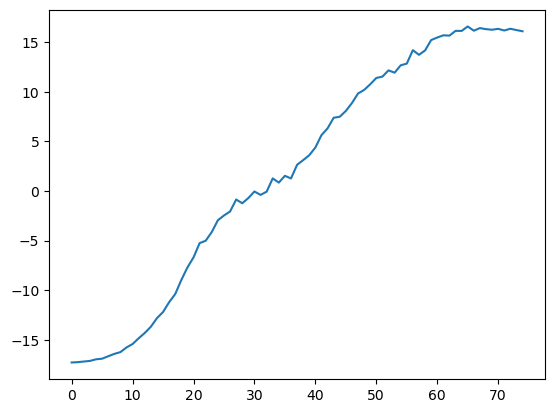

In [6]:
# run meehan on halfmoons over parameter space of bandwidths
p = Halfmoons(noise=0.1).fit()
X_train = p.sample(2000)
X_test = p.sample(1000)


det = ThreeSampleDetector(k=5)
sigmas = np.logspace(-3, 1, 75)
params = ParameterGrid({'bandwidth': sigmas})

C_Ts = det.run_params(Q=KDE, params=params, X_train=X_train, X_test=X_test, num_trials=1).flatten()

plt.plot(C_Ts)
plt.show()

In [7]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

p0 = [max(C_Ts), np.median(C_Ts),1,min(C_Ts)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, np.arange(0,75), C_Ts, p0)

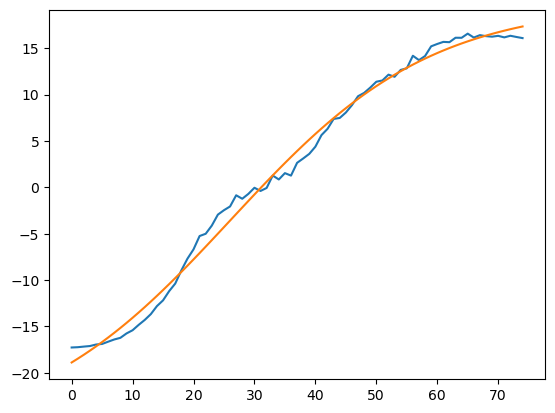

In [8]:
# plot the results
plt.plot(C_Ts)
plt.plot(sigmoid(np.arange(0,75), *popt), label='fit')
plt.show()

In [9]:
popt

array([ 46.62155078,  26.05332217,   0.06058852, -26.8570434 ])

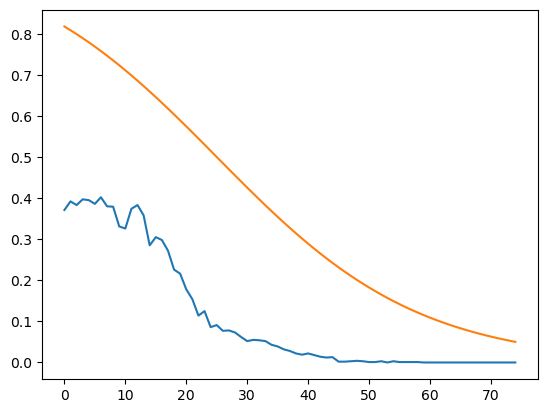

In [10]:
# run data copy detect over same space
det = DataCopyingDetector()
sigmas = np.logspace(-3, 1, 75)
params = ParameterGrid({'bandwidth': sigmas})

cr_q = np.zeros(len(sigmas))
for i, sigma in enumerate(sigmas):
    q = KDE(bandwidth=sigma).fit(X_train)
    cr_q[i] = det.estimate_cr(S=X_train, q=q, m=1000)

# plot 
plt.plot(cr_q)
plt.plot(1-sigmoid(np.arange(0,75), *[1, 25, 0.06, 0]), label='fit')

**Advantages:** 
- Possibility to provide an estimate how much data copying is going on.

**Disadvantages:**
- We ignore two of the fitted parameters to ensure that the values are between 0 and 1. An disadvantage to this is that the values are not always between -20 and 20 like the results of Meehan et al. suggest but depend a lot on the hyperparameter $k$, i.e. the number of regions.
- Need a parameter space we iterated over and additionally be sure that at the edges of the parameter space we have strict data copying and no data copying. This is not always the case.
